In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from pyhmc_minimal.hmcparameter import HMCParameter
from pyhmc_minimal.hmc import HMC

### This is the true distribution we would like to sample from.

### It is a 2D distribution shaped as a banana.

``` _
//\
V  \
 \  \_
  \,'.`-.
   |\ `. `.       
   ( \  `. `-.                        _,.-:\
    \ \   `.  `-._             __..--' ,-';/
     \ `.   `-.   `-..___..---'   _.--' ,'/
      `. `.    `-._        __..--'    ,' /
        `. `-_     ``--..''       _.-' ,'
          `-_ `-.___        __,--'   ,'
             `-.__  `----"""    __.-'
                  `--..____..--'
```

$\pi \left( x \right) \propto \exp{ \left[ - \frac{1}{2\sigma_d^2} \left( \mu_d  - g \left( x \right) \right) ^2 \right] } \exp{ \left[ - \frac{1}{2\sigma_x^2} ||x||_2^2 \right]}$

The first part of the right hand side is identified as the likelihood and the second as the prior.

We define:

$g \left( x \right) = 10 x_1 + x_2 ^2 $


In [2]:
def g(x):
    return 10 * x[0] + x[1] ** 2

def prior(x, sig_x):
    return np.exp(- np.dot(x / sig_x, x / sig_x) / 2)

def likelihood(x, mu_d, sig_d):
    return np.exp(- (mu_d - g(x)) ** 2 / (2 * sig_d ** 2))

#### Plotting the true distribution on a grid

In [3]:
# Helper functions

def calc_posterior(x, mu_d, sig_x, sig_d):
    return prior(x, sig_x) * likelihood(x, mu_d, sig_d)

def calc_post_on_grid(x1s, x2s, mu_d, sig_x, sig_d):
    res = np.zeros((len(x1s), len(x2s)))
    for i, x1 in enumerate(x1s):
        for j, x2 in enumerate(x2s):
            res[i, j] = calc_posterior(np.array([x1, x2]), mu_d, sig_x, sig_d)
    return res

In [4]:
# Difining the distribution's parameters
mu_d = 4.
sig_x = 5.
sig_d = 4.

# Generating a grid
lim = 15
x1 = np.arange(-lim, lim, 0.1)
x2 = np.arange(-lim, lim, 0.1)
grid = np.meshgrid(x1, x2)

y = calc_post_on_grid(x1, x2, mu_d, sig_x, sig_d)

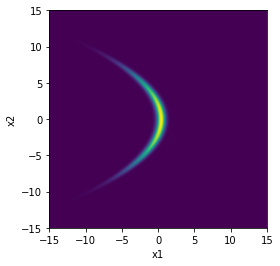

In [5]:
plt.imshow(y.T, extent=[-lim,lim,-lim,lim])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

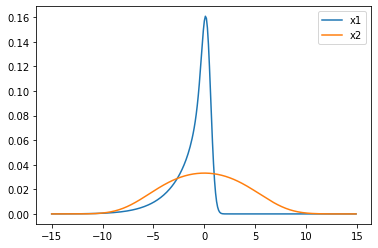

In [6]:
plt.plot(x1, y.mean(axis=-1), label='x1')
plt.plot(x2, y.mean(axis=0), label='x2')
plt.legend()
plt.show()

### Using HMC to sample from the banana distribution

#### Defining the state and velocity objects

In [7]:
def grad_g(x):
    if x.shape[0] > 2:
        res = np.zeros(x.shape)
        res[0] = 10
        res[1] = 2 * x[1]
        return res
    else:
        return np.array([10, 2 * x[1]])

class StateParam(HMCParameter):
    def __init__(self, init_val, mu_d, sig_x, sig_d):
        self.value = init_val
        
        self.mu_d = mu_d
        self.sig_x = sig_x
        self.sig_d = sig_d
    
    # the energy is the negative log likelihood
    def likelihood_energy(self, x):
        return (self.mu_d - g(x)) ** 2 / (2 * self.sig_d ** 2)

    def likelihood_energy_grad(self, x):
        return grad_g(x) * (g(x) - self.mu_d) / self.sig_d ** 2
    
    def prior_energy(self, x):
        return np.dot(x / sig_x, x / sig_x) / 2
    
    def get_prior_energy(self):
        return np.dot(self.value / sig_x, self.value / sig_x) / 2
    
    def get_g(self):
        return g(self.value)

    def prior_energy_grad(self, x):
        return x / self.sig_x ** 2
    
    def get_prior_energy_grad(self):
        return self.value / self.sig_x ** 2
        
    def get_energy_grad(self):
        return self.likelihood_energy_grad(self.value) + self.prior_energy_grad(self.value)

    def get_energy_for_value(self, x):
        return self.likelihood_energy(x) + self.prior_energy(x)

    def get_energy(self, *args):
        return self.get_energy_for_value(self.value)

In [8]:
class VelParam(HMCParameter):
    def __init__(self, init_val, sigma=None):

        super().__init__(np.array(init_val))
        self.mu = np.zeros(init_val.shape)
        if sigma is None:
            self.sigma = np.array(init_val)
        else:
            self.sigma = np.array(sigma)
        
    def gen_init_value(self):
        self.value = multivariate_normal.rvs(self.mu, self.sigma)

    def get_energy_grad(self):
        return self.value / self.sigma

    def get_energy(self):
        value = self.value
        return self.get_energy_for_value(value)

    def get_energy_for_value(self, value):
        return np.dot(value / np.sqrt(self.sigma), value / np.sqrt(self.sigma)) / 2

#### Initializing the state and velocity objects

In [9]:
D = 2
init_val_state = multivariate_normal.rvs(np.zeros(D), sig_x)
init_val_vel = np.ones(D)
sigma_vel = 0.1 * np.ones(D)
state = StateParam(init_val_state, mu_d, sig_x, sig_d)
velocity = VelParam(init_val_vel, sigma_vel)

#### Initializing the sampler's parameters

In [10]:
delta = 0.05 # step size
n = 10 # number of leapfrog steps in each iteration
num_samples = 5000 # number of iterations
hmc = HMC(state, velocity, delta, n, num_samples)

#### Running the sampler

In [11]:
hmc.HMC()

In [12]:
samps = np.array(hmc.get_samples())

#### Analysis

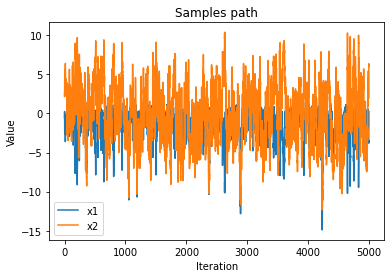

In [13]:
# We can plot the samples path to see if there are noticeable correlations

plt.plot(samps[:,0], label='x1')
plt.plot(samps[:,1], label='x2')
plt.ylabel('Value')
plt.xlabel('Iteration')
plt.title('Samples path')
plt.legend()
plt.show()

In [14]:
burnin = 10
thinning = 2

x1_samps = samps[burnin::thinning, 0]
x2_samps = samps[burnin::thinning, 1]

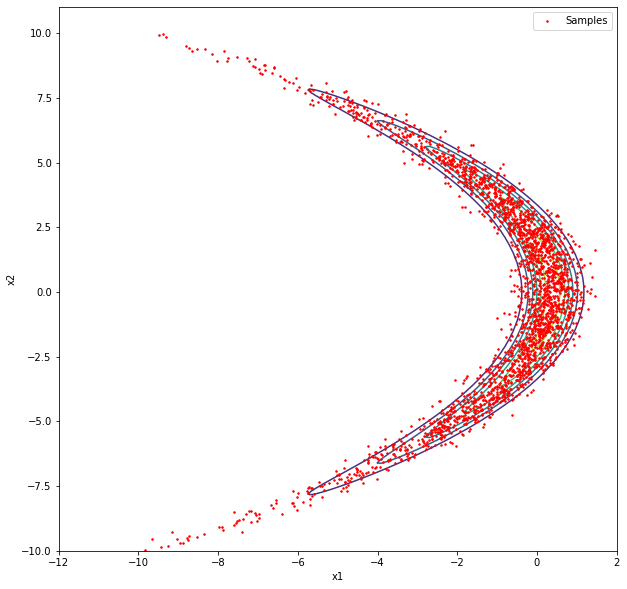

In [15]:
# And look at the 2D samples on the ground truth contour
plt.figure(figsize=(10,10))
plt.contour(x1, x2, y.T)
plt.plot(x1_samps, x2_samps, '.', markersize=3, color='red', label='Samples')
plt.xlim(-12,2)
plt.ylim(-10, 11)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()